# Money Ball 1 - Which teams will make the 2023 World Series?

* Marcos Fassio Bazzi - marcosfassiob18
* Peter Do - kyungwan
* Grant Collier - gcollier24
* Ajay Kanjoor - ajkanjoor03

Our goal for this project is to try to predict the 2023 MLB season and predict who will make the World Series based off of the data we can find on [Baseball Reference](https://www.baseball-reference.com/) and [Spotrac](https://www.spotrac.com/mlb/payroll/2022/), two websites dedicated to baseball statistics and payroll data, respectively.

## How does the MLB Regular Season work and how do teams make the World Series?

Major League Baseball is split up into two leagues: National League and American League. For each league, there are three conferences (East, Central and West) and each conference has five teams, making a total of 30 teams in MLB. Each team plays the four other teams in their division 19 times and the 10 other teams in their conference between six and seven times. This totals to 162 games for every team in the regular season. 

This year, 12 teams (six from each conference) make playoffs. The playoffs are stuctured as a six-team seeded single-elimination bracket, where one side represents the Atlantic League and the other representing the National League. In each conference, the #1 and #2 seed automatically advance to the semifinals while the #3 to #6 seends play in the quarterfinals. The winners of each conference make it to the World Series.

Below is a visualization of the MLB Playoffs format: 

![assets/playoffs_format.jpeg](assets/playoffs_format.jpeg)

For more information on the playoffs format, click [here](https://www.mlb.com/news/mlb-playoff-format-faq)

# Scraping, cleaning, grouping and visualizing the data

Exporting the data from Baseball Reference is easy enough - the site has an option that allows us to share and export as a `.csv` file. However, the same cannot be said for Spotrac. In this case, we used Python libraries `requests` and `BeautifulSoup4` to fetch and scrape the payroll data from Spotrac.

## Importing necessary libraries

In [91]:
import requests
import bs4
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances

In [92]:
plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline

warnings.filterwarnings("ignore")

## Scraping and cleaning the 2022 payroll data

In [93]:
# fetch link and get page
url = "https://www.spotrac.com/mlb/payroll/2022/"
header = { "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36" }
link = requests.get(url, headers=header)
soup = bs4.BeautifulSoup(link.content, "html5lib")

## get table and parse headers
table_data = soup.find('table', { "class": "datatable" })
headers = [i.text.strip() for i in table_data.find_all("th")]

## parse table body
table_body = soup.find("tbody")
team_data = []
for row_data in table_body.find_all("tr"):
    team_data += [[entry.text.strip().replace("\n", "").replace("\t", "") for entry in row_data.find_all("td")]]

# clean team names
for i in range(len(team_data)):
    team_data[i][1] = team_data[i][1][:-3] # last three characters are the team's abbreviation - we don't want this
team_data[4][1] = "San Diego Padres" # for whatever reason this entry's abbreviation was two characters instead of three
team_data.pop(14)
team_data.pop(14) # get rid of league averages in table

# turn data into dataframe
dirty_payroll_data_2022 = pd.DataFrame(team_data, columns=headers)

# cleaning 2022 payroll data
payroll_data_2022 = dirty_payroll_data_2022.copy()
payroll_data_2022 = dirty_payroll_data_2022.replace('0-','0').replace('\$','',regex=True).replace(',','', regex=True)
payroll_data_2022 = payroll_data_2022.loc[:, ['Team', '2022 Total Payroll']]
payroll_data_2022 = payroll_data_2022.astype({ '2022 Total Payroll':'int' })

payroll_data_2022.head()

,Team,2022 Total Payroll
0,Los Angeles Dodgers,270381426
1,New York Mets,268292506
2,New York Yankees,252957200
3,Philadelphia Phillies,244484097
4,San Diego Padres,224511694


## Scraping and cleaning the 2023 payroll data

The process is identical.

In [94]:
# fetch link and get page
url = "https://www.spotrac.com/mlb/payroll/2023/"
header = { "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36" }
link = requests.get(url, headers=header)
soup = bs4.BeautifulSoup(link.content, "html5lib")

## get table and parse headers
table_data = soup.find('table', { "class": "datatable" })
headers = [i.text.strip() for i in table_data.find_all("th")]

## parse table body
table_body = soup.find("tbody")
team_data = []
for row_data in table_body.find_all("tr"):
    team_data += [[entry.text.strip().replace("\n", "").replace("\t", "") for entry in row_data.find_all("td")]]

# clean team names
for i in range(len(team_data)):
    team_data[i][1] = team_data[i][1][:-3] # last three characters are the team's abbreviation - we don't want this
team_data[4][1] = "San Diego Padres" # for whatever reason this entry's abbreviation was two characters instead of three
team_data.pop(14) # get rid of league averages in table
team_data.pop(14)
team_data.pop(14)
team_data.pop(14)

# turn data into dataframe
dirty_payroll_data_2023 = pd.DataFrame(team_data, columns=headers)

# cleaning 2023 payroll data
payroll_data_2023 = dirty_payroll_data_2023.copy()
payroll_data_2023 = dirty_payroll_data_2023.replace('0-','0').replace('\$','',regex=True).replace(',','', regex=True)
payroll_data_2023 = payroll_data_2023.loc[:, ['Team', '2023 Total Payroll']]
payroll_data_2023 = payroll_data_2023.astype({ '2023 Total Payroll':'int' })

payroll_data_2023.head()

,Team,2023 Total Payroll
0,New York Mets,346462583
1,New York Yankees,279047473
2,San Diego Padre,245841064
3,Philadelphia Phillies,243446676
4,San Diego Padres,227499267


## Fetching the necessary data from 2022 MLB team data from Baseball Reference

One problem we noticed while exporting the data from Baseball Reference is that a lot of the columns in these tables are unecessary and don't provide much insight, such as the number of games played. While revising this project for Part 3, we picked out the more significant columns, such as a team's runs batted in or slugs.

Another shortcoming we had to deal with is renaming some columns that overlapped on the batting and pitching data. We solved this by subscripting said columns with `x` for the batting data and `y` for the pitching data.

We copied both the batting and pitching data per team as a `.csv` file and exported it, and then renamed the `Tm` column to `Team` to group our data more easily.

In [95]:
batting_data_2022_raw = pd.read_csv("data/batting_data_2022.csv")
batting_data_2022 = batting_data_2022_raw.rename(columns={ "Tm": "Team" })

batting_data_2022.head()

,Team,R,H,HR,RBI,SO,BA,OBP,SLG,OPS,OPS+,TB
0,Arizona Diamondbacks,702,1232,173,658,1341,0.230,0.304,0.385,0.689,95,2061
1,Atlanta Braves,789,1394,243,753,1498,0.253,0.317,0.443,0.761,111,2443
2,Baltimore Orioles,674,1281,171,639,1390,0.236,0.305,0.390,0.695,97,2119
3,Boston Red Sox,735,1427,155,704,1373,0.258,0.321,0.409,0.731,102,2268
4,Chicago Cubs,657,1293,159,620,1448,0.238,0.311,0.387,0.698,96,2097


In [96]:
pitching_data_2022_raw = pd.read_csv("data/pitching_data_2022.csv")
pitching_data_2022 = pitching_data_2022_raw.rename(columns={ "Tm": "Team" })

pitching_data_2022.head()

,Team,W-L%,ERA,tSho,H,R,HR,BB,SO,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
0,Arizona Diamondbacks,0.457,4.25,10,1345,740,191,504,1216,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41
1,Atlanta Braves,0.623,3.46,9,1224,609,148,500,1554,118,3.46,1.191,7.6,0.9,3.1,9.7,3.11
2,Baltimore Orioles,0.512,3.97,15,1406,688,171,443,1214,102,4.03,1.290,8.8,1.1,2.8,7.6,2.74
3,Boston Red Sox,0.481,4.53,10,1411,787,185,526,1346,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56
4,Chicago Cubs,0.457,4.00,11,1342,731,207,540,1383,103,4.33,1.304,8.4,1.3,3.4,8.6,2.56


## Grouping the 2022 payroll and baseball data

After cleaning the data above, we grouped the data together using two many-to-one joins based on the team name.

In [97]:
baseball_data_2022 = pd.merge(batting_data_2022, pitching_data_2022, on=["Team"]) # merge baseball reference stats
baseball_data_2022 = pd.merge(baseball_data_2022, payroll_data_2022, on=["Team"]) # merge payroll stats

baseball_data_2022.head()

,Team,R_x,H_x,HR_x,RBI,SO_x,BA,OBP,SLG,OPS,...,SO_y,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,2022 Total Payroll
0,Arizona Diamondbacks,702,1232,173,658,1341,0.230,0.304,0.385,0.689,...,1216,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41,85964090
1,Atlanta Braves,789,1394,243,753,1498,0.253,0.317,0.443,0.761,...,1554,118,3.46,1.191,7.6,0.9,3.1,9.7,3.11,183438888
2,Baltimore Orioles,674,1281,171,639,1390,0.236,0.305,0.390,0.695,...,1214,102,4.03,1.290,8.8,1.1,2.8,7.6,2.74,44888388
3,Boston Red Sox,735,1427,155,704,1373,0.258,0.321,0.409,0.731,...,1346,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56,211812131
4,Chicago Cubs,657,1293,159,620,1448,0.238,0.311,0.387,0.698,...,1383,103,4.33,1.304,8.4,1.3,3.4,8.6,2.56,151054737


### What does each statistic mean?

|Batting Data|Pitching Data|
|--|--|
|<table><thead><tr><th>Statistic</th><th>Description</th></tr></thead><tbody><tr><td>R_x</td><td>Runs</td></tr><tr><td>H_x</td><td>Hits</td></tr><tr><td>HR_x</td><td>Home runs</td></tr><tr><td>RBI</td><td>Runs batted in</td></tr><tr><td>SO_x</td><td>Strikeouts</td></tr><tr><td>BA</td><td>Batting average</td></tr><tr><td>OBP</td><td>On-base percentage</td></tr><tr><td>SLG</td><td>Slugs</td></tr><tr><td>OPS</td><td>OBP + slugs</td></tr><tr><td>OPS+</td><td>OPS normalized across league</td></tr><tr><td>TB</td><td>Total bases gained</td></tr></tbody></table>| <table><thead><tr><th>Statistic</th><th>Description</th></tr></thead><tbody><tr><td>W-L%</td><td>Win-loss percentage</td></tr><tr><td>ERA</td><td>Earned run average</td></tr><tr><td>tSho</td><td>Team shutouts</td></tr><tr><td>H_y</td><td>Hits allowed</td></tr><tr><td>R_y</td><td>Runs allowed</td></tr><tr><td>HR</td><td>Home runs allowed</td></tr><tr><td>BB</td><td>Base on balls (walks)</td></tr><tr><td>SO_y</td><td>Shutouts</td></tr><tr><td>ERA+</td><td>Earned run average (normalized)</td></tr><tr><td>FIP</td><td>Fielding independent pitching</td></tr><tr><td>WHIP</td><td>Walks and hits per inning pitched</td></tr><tr><td>HR9</td><td>Home runs per nine innings</td></tr><tr><td>BB9</td><td>Walks per nine innings</td></tr><tr><td>SO9</td><td>Shutouts per nine innings</td></tr><tr><td>SO/W</td><td>Shutouts per walk</td></tr></tbody></table>|

More on what each statistic means [here](https://www.baseball-reference.com/bullpen/Baseball_statistics#:~:text=Batting%20average%2C%20RBIs%2C%20and%20home,most%20often%20cited%20traditional%20statistics.)

# Processing our 2022 data and finding the best statistics

Now that we scraped, cleaned and grouped the data we needed, our next step is to correlate what data leads to the highest win ratio. We all agreed on using the win-loss ratio as our benchmark because the team with the highest win ratio makes it to the highest seed in playoffs, thus making said team's chances to make the World Series a lot higher.

Our plan is to normalize our data and create a correlation matrix using the normalized data. From the correlation matrix we will be able to determine what statistics have the highest correlation with the `W-L%` statistic. Once we find this out, our next step is to use data from the current season to try to pick the two teams that will make the 2023 World Series.

## Normalizing our 2022 baseball data

A lot of the statistics and numerics in our data vary very largely between columns, so we z-scored our data to standardize our statistics and make our calculations more accurate and precise.

In [98]:
norm = (baseball_data_2022 - baseball_data_2022.mean())/baseball_data_2022.std()
norm = norm.drop('Team', axis=1)
norm.head()

,2022 Total Payroll,BA,BB,BB9,ERA,ERA+,FIP,H9,HR9,HR_x,...,R_y,SLG,SO/W,SO9,SO_x,SO_y,TB,W-L%,WHIP,tSho
0,-1.031087,-1.045480,0.116346,0.220102,0.511520,-0.550141,0.896170,0.373667,0.573168,-0.087932,...,0.519080,-0.421867,-0.829994,-1.201344,-0.163264,-1.235463,-0.617376,-0.487061,0.301386,-0.380747
1,0.447377,0.798960,0.041995,-0.062886,-0.894501,1.031515,-1.352872,-1.002106,-1.283897,1.890547,...,-0.910815,1.787643,0.729339,1.606993,1.337983,1.558796,1.747129,1.290632,-0.719544,-0.614388
2,-1.654110,-0.564322,-1.017515,-0.911850,0.013184,-0.068768,0.120638,0.832257,-0.045853,-0.144460,...,-0.048512,-0.231392,-0.094880,-1.341761,0.305278,-1.251997,-0.258367,0.101934,0.271358,0.787455
3,0.877733,1.199926,0.525280,0.503090,1.009857,-0.687677,0.482553,0.985121,0.573168,-0.596684,...,1.032095,0.492413,-0.495852,-0.078009,0.142723,-0.160748,0.663914,-0.230045,0.911942,-0.380747
4,-0.043815,-0.403935,0.785510,0.786077,0.066577,0.000000,0.896170,0.220803,1.192190,-0.483628,...,0.420843,-0.345677,-0.495852,0.062407,0.859879,0.145132,-0.394543,-0.487061,0.411486,-0.147107


## Creating a scatterplot matrix with the 2022 baseball data

Using this scatterplot matrix we will be able to see how correlated different statistics are to each other. We are interested in seeing which statistics are most correlated to win percentage.

In [99]:
# scatter_matrix = pd.plotting.scatter_matrix(norm, figsize=(25,25))

# scatter_matrix; # semicolon suppresses text output

## Creating the win-loss correlation table 

We find the win-loss correlation table by using the `corr()` function to create a correlation matrix. Then, we create another table sorting it by `W-L%`. A correlation of $\pm 0.7$ is considered highly correlated.

In [100]:
cmatrix = norm.corr()

win_loss_table = cmatrix[['W-L%']].sort_values(by='W-L%', ascending=True)
win_loss_table.head()

,W-L%
FIP,-0.898314
R_y,-0.890831
WHIP,-0.888682
ERA,-0.877022
BB9,-0.805288


## Win percentage correlation bar graph

The table above doesn't do a good job at showing what statistics win-loss ratio is best correlated to. This bar graph, however, does.

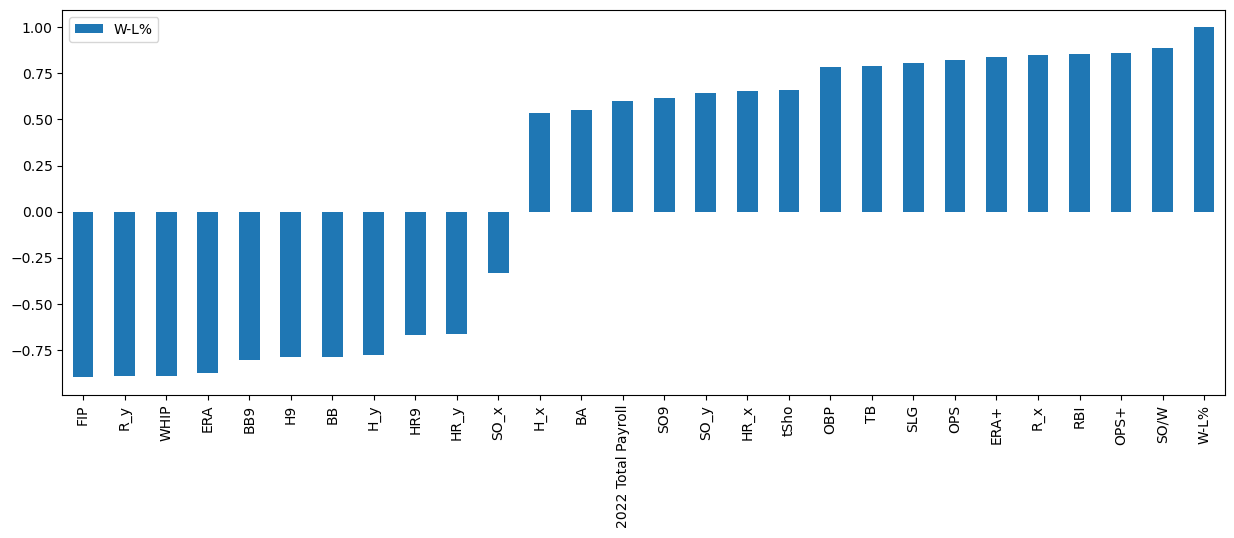

In [101]:
win_loss_table.plot.bar(figsize=(15, 5)); # semicolon suppresses text output

## Further Inquiry

### What are the best statistics at predicting Win Ratio?

We found that BB, BB9, ERA, FIP, H9, R_y, WHIP, ERA+, OBP, OPS, OPS+, RBI, R_x, SLG, SO/W, and TB all had an R value of above 0.7 or below -0.7 which shows a very strong correlation to win ratio.

### Are advanced statistics better predictors than regular stats?

Out of the 16 statistics that have a strong correlation with win ratio, 12 of them are advanced statistics.

### How important is payroll?

Payroll only had an R value of 0.6, which is much lower than we expected.

### Is a good offense or a good defense more important?

Out of the 16 statistics that have a strong correlation with win ratio, 9 of them are pitching statistics. But, 4 of the top 5 stats with the highest correlation to win ratio are pitching stats. So, defense is more important than offense when it comes to getting wins.

## Using MDS dimension reduction to determine which baseball statistics are most similar to each other

In [102]:
distance_table = norm.transpose()
distance_table.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2022 Total Payroll,-1.031087,0.447377,-1.654110,0.877733,-0.043815,0.747188,-0.583592,-1.326654,-0.211304,-0.267798,...,1.501807,-1.600181,1.373290,-1.482781,1.070356,-0.577956,0.037690,-0.059245,0.350801,-0.411558
BA,-1.045480,0.798960,-0.564322,1.199926,-0.403935,1.039540,-0.644515,0.879154,0.879154,-0.965287,...,-0.163356,-2.168183,0.798960,-1.687024,-0.163356,-1.045480,0.718767,-0.323742,1.681084,0.478188
BB,0.116346,0.041995,-1.017515,0.525280,0.785510,0.655395,2.123838,-1.166218,0.766922,0.246462,...,-0.998927,0.097759,-0.645757,1.640553,-0.552818,-0.943163,-0.162472,1.547614,-1.370684,1.120092
BB9,0.220102,-0.062886,-0.911850,0.503090,0.786077,0.503090,2.201017,-1.194838,0.786077,0.220102,...,-0.911850,0.220102,-0.628862,1.635041,-0.628862,-0.911850,-0.062886,1.352053,-1.477826,1.352053
ERA,0.511520,-0.894501,0.013184,1.009857,0.066577,-0.075805,1.597182,-0.894501,1.953137,0.137768,...,-1.179265,0.992059,0.013184,1.241228,-0.271580,-0.663131,-0.307176,0.458127,-0.164794,1.846351


In [103]:
distHD = euclidean_distances(distance_table)
distHD = pd.DataFrame(distHD, columns=distance_table.index, index=distance_table.index)

distHD.head()

,2022 Total Payroll,BA,BB,BB9,ERA,ERA+,FIP,H9,HR9,HR_x,...,R_y,SLG,SO/W,SO9,SO_x,SO_y,TB,W-L%,WHIP,tSho
2022 Total Payroll,0.000000,4.341788,8.380112,8.441126,8.699686,5.061883,9.023466,8.730651,8.448741,5.240763,...,8.757602,4.124261,4.703248,4.657887,7.669601,4.686690,4.008852,4.549138,8.799619,4.638797
BA,4.341788,0.000000,8.526485,8.579887,8.097245,5.844182,8.532202,7.727355,7.976428,6.363597,...,8.086610,3.863357,5.239150,5.865250,9.064829,5.870039,3.253587,4.822930,8.133410,6.017484
BB,8.380112,8.526485,0.000000,0.535646,3.741818,9.094004,3.952550,4.858935,5.486627,8.313267,...,3.530929,8.828043,9.781283,8.186502,5.306738,8.257035,8.807597,9.642812,3.326440,9.000867
BB9,8.441126,8.579887,0.535646,0.000000,3.582088,9.145635,3.736202,4.709611,5.355575,8.376572,...,3.435011,8.889619,9.826002,8.303863,5.464145,8.381029,8.885509,9.688911,3.176031,9.010800
ERA,8.699686,8.097245,3.741818,3.582088,0.000000,9.910338,2.346752,1.855167,4.109579,9.016125,...,0.846658,9.012665,9.768763,9.121033,6.556649,9.209771,8.923525,9.879533,1.234302,9.346943


In [104]:
mds = MDS(n_components=2, dissimilarity='precomputed')
data2D = mds.fit_transform(distHD)
data2D = pd.DataFrame(data2D, columns=['X', 'Y'], index=distance_table.index)

data2D.head()

,X,Y
2022 Total Payroll,3.636293,-0.403482
BA,2.175937,0.331109
BB,-5.435040,1.520359
BB9,-5.419827,1.737409
ERA,-4.030137,3.956615


## MDS plot

This plot shows which statistics are most similar to each other. The plot only indicates the distance between each statistic, the close two stats are to each other the more similar they are. We are interested in which statistics are closest to W-L%.

<Axes: xlabel='X', ylabel='Y'>

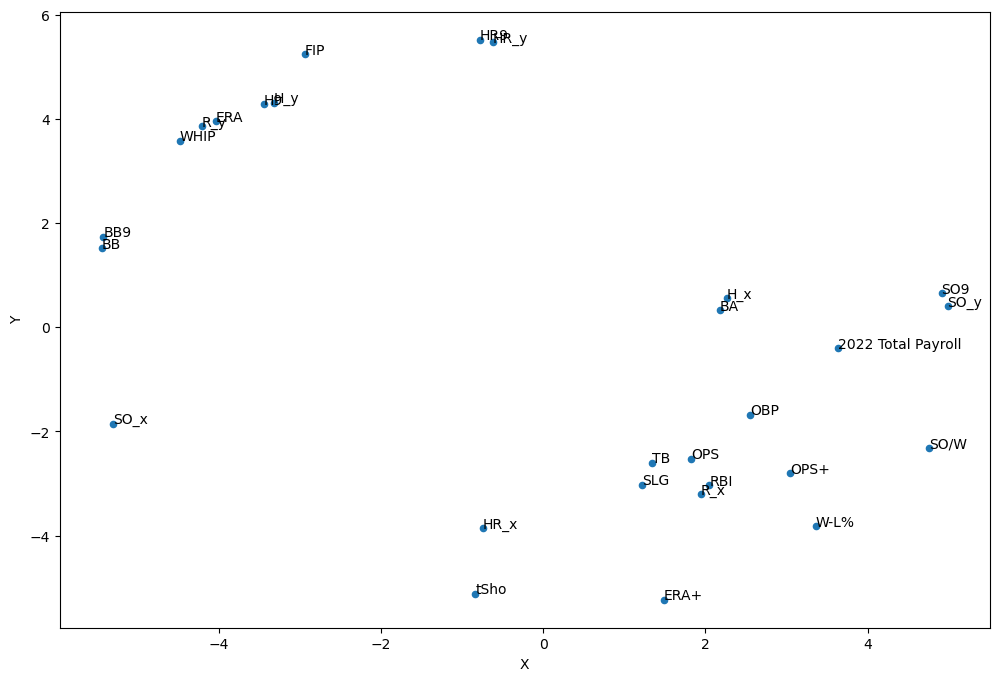

In [105]:
plot = data2D.plot.scatter(x='X', y='Y')
for i,r in data2D.iterrows():
    plot.text(r.X, r.Y, i)

plt.rcParams["figure.figsize"] = (10, 10)
plot

The MDS plot tells us how similar the different statistics are to each other. The Stats that are very close to `W-L%` are very good predictors. But interestingly enough the stats that are furthest away are also good predictors but they are inversely related to W-L% so they are very dissimilar. It's the statistics that are in the middle, a medium distance away from W-L% that are the worst predictors.

Based on our findings and the MDS plot above, **the teams with the highest above-average batting data and the teams with the lowest below-average pitching data are the teams that have the highest chance of making the World Series.**

# Using the 2023 baseball data to find out which teams will make the 2023 World Series

## Exporting, grouping and normalizing the data

We exported the 2023 data from Baseball Reference and omitted every other statistic that isn't highly correlated with win-loss ratio. That is, the only statistics that had a correlation of $\pm 0.7$ stayed in this `.csv` file.

In [106]:
batting_data_2023 = pd.read_csv("data/batting_2023.csv")
pitching_data_2023 = pd.read_csv("data/pitching_2023.csv")
baseball_data_2023 = pd.merge(batting_data_2023, pitching_data_2023, on=["Tm"])

team_initials = ["ARI", "ATL", "BAL", "BOS", "CHC", "CWS", "CIN", "CLE", "COL", "DET", "HOU", "KC", "LAA", "LAD", "MIA", 
                 "MIL", "MIN", "NYM", "NYY", "OAK", "PHI", "PIT", "SD", "SEA", "SF" , "STL", "TB", "TEX", "TOR", "WSH"]
baseball_data_2023.insert(1, "Initials", team_initials)
baseball_data_2023.head()

,Tm,Initials,R_x,RBI,OBP,SLG,OPS,OPS+,TB,GDP,ERA,R_y,BB,ERA+,FIP,WHIP,H9,BB9,SO/W
0,Arizona Diamondbacks,ARI,121,116,0.312,0.412,0.723,99,358,22,4.62,123,106,95,4.85,1.351,8.0,4.2,2.03
1,Atlanta Braves,ATL,130,123,0.340,0.459,0.799,114,392,22,3.38,90,80,133,3.65,1.237,7.9,3.2,2.88
2,Baltimore Orioles,BAL,125,121,0.336,0.419,0.755,111,331,22,4.19,104,71,108,4.09,1.253,8.3,3.0,3.03
3,Boston Red Sox,BOS,146,138,0.329,0.429,0.758,106,378,21,5.13,138,80,93,4.74,1.373,9.2,3.2,2.75
4,Chicago Cubs,CHC,130,124,0.347,0.443,0.790,117,355,13,3.57,87,78,123,3.80,1.166,7.1,3.4,2.86


### Normalizing current data

We normalized the given data for the same reason we normalized the 2022 data - each statistic has a very high variance between different columns and measurements, and z-scoring our data will make results more accurate.

In [107]:
norm = (baseball_data_2023 - baseball_data_2023.mean())/baseball_data_2023.std()
norm = norm.drop(['Tm', 'Initials'], axis=1)

norm.head()

,BB,BB9,ERA,ERA+,FIP,GDP,H9,OBP,OPS,OPS+,RBI,R_x,R_y,SLG,SO/W,TB,WHIP
0,1.459904,1.240043,0.324114,-0.595994,0.853321,1.067633,-0.421365,-0.365707,0.034946,-0.059516,0.358804,0.387628,0.408267,0.247374,-1.234704,0.583088,0.275796
1,-0.239686,-0.363461,-0.946387,1.317902,-1.046466,1.067633,-0.533232,1.056486,1.341113,0.896992,0.698214,0.816561,-0.921286,1.376170,0.425020,1.456435,-0.518162
2,-0.828005,-0.684162,-0.116463,0.058760,-0.349877,1.067633,-0.085765,0.853316,0.584911,0.705690,0.601240,0.578265,-0.357234,0.415493,0.717912,-0.110453,-0.406730
3,-0.239686,-0.363461,0.846659,-0.696725,0.679174,0.813434,0.921038,0.497767,0.636470,0.386854,1.425520,1.579108,1.012609,0.655662,0.171179,1.096822,0.429016
4,-0.370423,-0.042760,-0.751713,0.814245,-0.808992,-1.220152,-1.428167,1.412034,1.186436,1.088294,0.746701,0.816561,-1.042155,0.991899,0.385967,0.506028,-1.012645


### Predicting what teams will make the World Series

As of right now (4/27/2023), each team has played about 25 games. From this, we can determine who will make the World Series by finding out which teams have the highest batting data and lowest pitching data. We came to this conclusion because as shown above, we determined that pitching data has an inverse correlation with a team's win-loss ratio while batting data has a direct correlation with a team's win-loss ratio.

### Top 5 batting teams

In [108]:
batting_norm_table = norm.loc[:, ['ERA+', 'OBP', 'OPS', 'OPS+', 'RBI', 'R_x', 'SLG', 'SO/W', 'TB']] 
batting_sum = batting_norm_table.sum(axis=1)

batting_norm_table.insert(0, "Team", batting_data_2023["Tm"])
batting_norm_table.insert(1, "Initials", baseball_data_2023["Initials"])
batting_norm_table.insert(2, "Sum", batting_sum)

batting_results = pd.DataFrame(batting_norm_table[["Team", "Initials", "Sum"]])
batting_results = batting_results.sort_values(by="Sum", ascending=False)
batting_results.head()

,Team,Initials,Sum
26,Tampa Bay Rays,TB,18.807895
27,Texas Rangers,TEX,10.276071
1,Atlanta Braves,ATL,9.384893
4,Chicago Cubs,CHC,7.948164
3,Boston Red Sox,BOS,5.752657


### Top 5 pitching teams

In [109]:
pitching_norm_table = norm.loc[:, ['BB', 'BB9', 'ERA', 'FIP', 'H9', 'R_y', 'WHIP']] 
pitching_sum = pitching_norm_table.sum(axis=1)

pitching_norm_table.insert(0, "Team", batting_data_2023["Tm"])
pitching_norm_table.insert(1, "Initials", baseball_data_2023["Initials"])
pitching_norm_table.insert(2, "Sum", pitching_sum)

pitching_results = pd.DataFrame(pitching_norm_table[["Team", "Initials", "Sum"]])
pitching_results = pitching_results.sort_values(by="Sum", ascending=True)
pitching_results.head()

,Team,Initials,Sum
26,Tampa Bay Rays,TB,-9.861627
16,Minnesota Twins,MIN,-8.092079
10,Houston Astros,HOU,-5.881812
18,New York Yankees,NYY,-5.653704
4,Chicago Cubs,CHC,-5.456857


## Creating a regression line

## Credit

Everyone contributed to each part equally. This includes the web scraping, visualization, and analysis.